# Load model

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import scanpy as sc
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from scipy.sparse import issparse
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from typing import Literal

## load model
from model.model import *

/home/liuyinbo/anaconda3/envs/tg3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/liuyinbo/anaconda3/envs/tg3/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Download pre-trained weights

In [ ]:
!mkdir -p pretrainmodel
!curl -L -o pretrainmodel/model.safetensors "https://huggingface.co/microsoft/swin-tiny-patch4-window7-224/resolve/main/model.safetensors?download=true"

# Train model

### mode is train

In [ ]:
if __name__ == '__main__':
    # --- Hyperparameters ---
    DEVICE = "cuda:5" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 128  # Swin Transformer is large; reduce if GPU memory is insufficient.
    LATENT_DIM = 128
    LEARNING_RATE = 1e-4
    EPOCHS = 100

    # *** MODIFIED: Loss function weights, with the addition of alignment_weight ***
    LOSS_WEIGHTS = {
        "kld_weight": 0.5,        # Regularization term for VAE. KL annealing is recommended, so the initial beta can be small.
        "image_weight": 1.0,      # Image reconstruction loss weight.
        "rna_weight": 1.0,       # RNA reconstruction loss weight (NLL value is typically large and serves as a baseline).
        "alignment_weight": 0.5   # Weight for the new latent space alignment loss.
    }

    print(f"Using device: {DEVICE}")

    H5AD_PATH = 'preprocess/data/adata_slice151673.h5ad'
    Himg_PATH = f'preprocess/data/adata_h_img_151673.h5ad'
    adata_h5 = sc.read_h5ad(H5AD_PATH)
    adata_img = sc.read_h5ad(Himg_PATH)
    adata_rna = adata_h5[:, adata_h5.var['mode'] == 'RNA'].copy()

    # 1. Prepare Data
    train_loader, val_loader, test_loader, img_shape, rna_dim, spatial_dim, *_ = prepare_adata_loader(
        adata_img=adata_img, adata_rna=adata_rna,
        layer_key_img='rawX', shape_key_img='IMG_Shape',
        layer_key_rna='rawX', spatial_key='spatial',
        batch_size=BATCH_SIZE, ratio=(0.9, 0.1, 0.0)
    )
    C, H, W = img_shape

    # 2. Initialize Model
    model = MultiModalVAE(
        input_channels=C, spatial_dim=spatial_dim,
        latent_dim=LATENT_DIM,  img_size=H, rna_dim=rna_dim
    ).float()

    # 3. Train Model
    # NOTE: The KL annealing logic is implemented inside the training function.
    trained_model = train_multi_modal_vae(
        model=model, train_loader=train_loader, val_loader=val_loader,
        epochs=EPOCHS, learning_rate=LEARNING_RATE, device=DEVICE, fast_train=False,
        **LOSS_WEIGHTS
    )

Using device: cuda:5
--- Starting to prepare multi-modal data ---
Image data: torch.Size([3611, 3, 160, 160]), Spatial data: torch.Size([3611, 2]), RNA data: torch.Size([3611, 3271])
Data preparation complete. Training set: 3249, Validation set: 361, Test set: 1
Loading pretrained weights from local file: ./pretrainmodel/model.safetensors
Local weights loaded successfully!

--- Starting Multi-Modal VAE Model Training (Swin Transformer version) ---
Epoch: 1/100 | Loss: 637068.84 kld_w: 0.01 [Img: 16229.90, RNA: 4225.23, KLD: 1456.89, Align: 1233198.3035] | Val Spearman: 0.0354 | Val Pearson: 0.0375 | Val MSE: 0.3402
Epoch: 2/100 | Loss: 32619.00 kld_w: 0.02 [Img: 10690.76, RNA: 3727.38, KLD: 1905.42, Align: 36325.4906] | Val Spearman: 0.1109 | Val Pearson: 0.1181 | Val MSE: 0.2943
Epoch: 3/100 | Loss: 23432.72 kld_w: 0.03 [Img: 9665.34, RNA: 3478.61, KLD: 2000.37, Align: 20457.5074] | Val Spearman: 0.1715 | Val Pearson: 0.1797 | Val MSE: 0.2637
Epoch: 4/100 | Loss: 20594.50 kld_w: 0.04 

### mode is algne

In [ ]:
# if __name__ == '__main__':
#     # --- Hyperparameters ---
#     DEVICE = "cuda:5" if torch.cuda.is_available() else "cpu"
#     BATCH_SIZE = 128  # Swin Transformer is large; reduce if GPU memory is insufficient.
#     LATENT_DIM = 128
#     LEARNING_RATE = 1e-4
#     EPOCHS = 5

#     # *** MODIFIED: Loss function weights, with the addition of alignment_weight ***
#     LOSS_WEIGHTS = {
#         "kld_weight": 0.5,        # Regularization term for VAE. KL annealing is recommended, so the initial beta can be small.
#         "image_weight": 1.0,      # Image reconstruction loss weight.
#         "rna_weight": 10.0,       # RNA reconstruction loss weight (NLL value is typically large and serves as a baseline).
#         "alignment_weight": 0.5   # Weight for the new latent space alignment loss.
#     }

#     print(f"Using device: {DEVICE}")

#     H5AD_PATH = 'preprocess/data/adata_slice151673.h5ad'
#     Himg_PATH = f'preprocess/data/adata_h_img_151673.h5ad'
#     adata_h5 = sc.read_h5ad(H5AD_PATH)
#     adata_img = sc.read_h5ad(Himg_PATH)
#     adata_rna = adata_h5[:, adata_h5.var['mode'] == 'RNA'].copy()

#     # 1. Prepare Data
#     train_loader, val_loader, _, img_shape, rna_dim, spatial_dim, *_ = prepare_adata_loader(
#         adata_img=adata_img, adata_rna=adata_rna,
#         layer_key_img='rawX', shape_key_img='IMG_Shape',
#         layer_key_rna='rawX', spatial_key='spatial',
#         batch_size=BATCH_SIZE, ratio=(0.9, 0.1, 0.0)
#     )
#     test_loader_list = []
#     for d in [151674, 151675, 151676]:
#         print("\n--- Evaluating RNA prediction on test set ---")
#         H5AD_PATH = f'preprocess/data/adata_slice{d}.h5ad'
#         Himg_PATH = f'preprocess/data/adata_h_img_{d}.h5ad'
#         adata_h5 = sc.read_h5ad(H5AD_PATH)
#         adata_img = sc.read_h5ad(Himg_PATH)
#         adata_rna = adata_h5[:, adata_h5.var['mode'] == 'RNA'].copy()
#         test_loader, *_ = prepare_adata_loader(
#             adata_img=adata_img, adata_rna=adata_rna,
#             layer_key_img='rawX', shape_key_img='IMG_Shape',
#             layer_key_rna='rawX', spatial_key='spatial',
#             batch_size=BATCH_SIZE, ratio=(1.0, 0, 0)
#         )
#         test_loader_list.append(test_loader)
#     C, H, W = img_shape

#     # 2. Initialize Model
#     model = MultiModalVAE(
#         input_channels=C, spatial_dim=spatial_dim,
#         latent_dim=LATENT_DIM, img_size=H, rna_dim=rna_dim
#     ).float()

#     # 3. Train Model
#     # NOTE: The KL annealing logic is implemented inside the training function.
#     trained_model = train_multi_modal_vae(
#         model=model, train_loader=train_loader, val_loader=val_loader, test_loader_list=test_loader_list,
#         epochs=EPOCHS, learning_rate=LEARNING_RATE, device=DEVICE, fast_train=False, mode='algne', **LOSS_WEIGHTS
#     )

Using device: cuda:5
--- Starting to prepare multi-modal data ---
Image data: torch.Size([3611, 3, 160, 160]), Spatial data: torch.Size([3611, 2]), RNA data: torch.Size([3611, 3271])
Data preparation complete. Training set: 3249, Validation set: 361, Test set: 1

--- Evaluating RNA prediction on test set ---
--- Starting to prepare multi-modal data ---
Image data: torch.Size([3635, 3, 160, 160]), Spatial data: torch.Size([3635, 2]), RNA data: torch.Size([3635, 3271])
Data preparation complete. Training set: 3635, Validation set: 0, Test set: 0

--- Evaluating RNA prediction on test set ---
--- Starting to prepare multi-modal data ---
Image data: torch.Size([3566, 3, 160, 160]), Spatial data: torch.Size([3566, 2]), RNA data: torch.Size([3566, 3271])
Data preparation complete. Training set: 3566, Validation set: 0, Test set: 0

--- Evaluating RNA prediction on test set ---
--- Starting to prepare multi-modal data ---
Image data: torch.Size([3431, 3, 160, 160]), Spatial data: torch.Size([

# Inference and Evaluation

In [ ]:
import scanpy as sc
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr

# 1. Function Definitions (Ensure these functions are defined before running)
# These are the functions you provided for calculating MSE, median Pearson, and median Spearman correlations
def calculate_mse_col_normalized(y_pred, y_true, adata_with_norm=False):
    """
    Calculates the column-normalized Mean Squared Error (MSE).
    """
    if isinstance(y_pred, torch.Tensor): y_pred = y_pred.cpu().numpy()
    if isinstance(y_true, torch.Tensor): y_true = y_true.cpu().numpy()
    if not adata_with_norm:
        y_pred = np.log1p(y_pred)
        y_true = np.log1p(y_true)
    return mean_squared_error(y_pred, y_true)

def calculate_median_pearson(y_pred, y_true):
    """
    Calculates the median Pearson correlation for genes.
    """
    if isinstance(y_pred, torch.Tensor): y_pred = y_pred.cpu().numpy()
    if isinstance(y_true, torch.Tensor): y_true = y_true.cpu().numpy()
    correlations = [pearsonr(y_pred[:, i], y_true[:, i])[0] for i in range(y_pred.shape[1])]
    return np.median(np.nan_to_num(correlations, nan=0.0))

def calculate_spearman_correlation(pred_matrix, raw_matrix, axis=1):
    """
    Calculates the median Spearman correlation for genes.
    """
    correlations = []
    if pred_matrix.shape[0] == 0 or raw_matrix.shape[0] == 0: return 0.0
    for i in range(pred_matrix.shape[1]):
        corr, _ = spearmanr(pred_matrix[:, i], raw_matrix[:, i])
        correlations.append(corr)
    return np.nanmedian(np.nan_to_num(np.array(correlations), nan=0.0))

# 2. Loop through datasets
for d in [151674, 151675, 151676]:
    print("\n--- Evaluating RNA prediction on test set ---")
    trained_model.eval()
    predicted_rna_list, true_rna_list = [], []
    H5AD_PATH = f'preprocess/data/adata_slice{d}.h5ad'
    Himg_PATH = f'preprocess/data/adata_h_img_{d}.h5ad'
    adata_h5 = sc.read_h5ad(H5AD_PATH)
    adata_img = sc.read_h5ad(Himg_PATH)
    adata_rna = adata_h5[:, adata_h5.var['mode'] == 'RNA'].copy()
    train_loader, val_loader, test_loader, img_shape, rna_dim, spatial_dim, *_ = prepare_adata_loader(
        adata_img=adata_img, adata_rna=adata_rna,
        layer_key_img='rawX', shape_key_img='IMG_Shape',
        layer_key_rna='rawX', spatial_key='spatial',
        batch_size=BATCH_SIZE, ratio=(1.0, 0, 0)
    )
    with torch.no_grad():
        for (img_data, spatial_data, rna_data) in train_loader:
            img_data, spatial_data = img_data.to(DEVICE), spatial_data.to(DEVICE)
            _, recon_rna_params, _, _, _, _ = trained_model(img_data, spatial_data)
            predicted_rna_list.append(recon_rna_params['mu'].cpu().numpy())
            true_rna_list.append(rna_data.numpy())

    predicted_rna_matrix = np.vstack(predicted_rna_list)
    true_rna_matrix = np.vstack(true_rna_list)

    # 3. Calculate and print all metrics
    cell_spearman_correlations = calculate_spearman_correlation(predicted_rna_matrix, true_rna_matrix, axis=1)
    gene_mse = calculate_mse_col_normalized(predicted_rna_matrix, true_rna_matrix)
    gene_pearson_corr = calculate_median_pearson(predicted_rna_matrix, true_rna_matrix)

    print(f"\nFinal evaluation results (RNA) for slice {d}:")
    print(f"On the independent test set, median Spearman correlation (by gene): {cell_spearman_correlations:.4f}")
    print(f"On the independent test set, median Pearson correlation (by gene): {gene_pearson_corr:.4f}")
    print(f"On the independent test set, Mean Squared Error (MSE): {gene_mse:.4f}")


--- Evaluating RNA prediction on test set ---
--- Starting to prepare multi-modal data ---
Image data: torch.Size([3635, 3, 160, 160]), Spatial data: torch.Size([3635, 2]), RNA data: torch.Size([3635, 3271])
Data preparation complete. Training set: 3635, Validation set: 0, Test set: 0

Final evaluation results (RNA) for slice 151674:
On the independent test set, median Spearman correlation (by gene): 0.2248
On the independent test set, median Pearson correlation (by gene): 0.2485
On the independent test set, Mean Squared Error (MSE): 0.2170

--- Evaluating RNA prediction on test set ---
--- Starting to prepare multi-modal data ---
Image data: torch.Size([3566, 3, 160, 160]), Spatial data: torch.Size([3566, 2]), RNA data: torch.Size([3566, 3271])
Data preparation complete. Training set: 3566, Validation set: 0, Test set: 0

Final evaluation results (RNA) for slice 151675:
On the independent test set, median Spearman correlation (by gene): 0.1997
On the independent test set, median Pear

In [ ]:
import numpy as np
import torch
from scipy.stats import spearmanr
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
import warnings


def calculate_spearman_correlation_evaluate(pred_matrix, raw_matrix):
    """
    Calculates the Spearman correlation coefficients for all genes,
    replacing NaN values with 0, and returns the full list of coefficients
    and their median.
    
    Parameters:
        pred_matrix: Predicted RNA matrix (shape: [n_cells, n_genes]),
                     supports torch.Tensor or numpy.ndarray.
        raw_matrix: True RNA matrix (shape: [n_cells, n_genes]),
                    supports torch.Tensor or numpy.ndarray.
    
    Returns:
        all_correlations: A list of Spearman correlation coefficients for all genes
                          (NaNs replaced with 0, shape: [n_genes,]).
        median_corr: The median of the correlation coefficients (calculated
                     from the replaced data, reflects the overall correlation level).
    """
    # 1. Process input format: torch tensors -> numpy arrays on CPU
    if isinstance(pred_matrix, torch.Tensor):
        pred_matrix = pred_matrix.cpu().numpy()
    if isinstance(raw_matrix, torch.Tensor):
        raw_matrix = raw_matrix.cpu().numpy()

    # 2. Validate input: If matrices are empty (no cells), return a zero array and a median of 0.0
    if pred_matrix.shape[0] == 0 or raw_matrix.shape[0] == 0:
        warnings.warn("Input matrix is empty (no cells), returning all-zero correlations.")
        # If no genes, return an empty list; otherwise, return a zero array matching the number of genes
        n_genes = max(pred_matrix.shape[1], raw_matrix.shape[1]) if (pred_matrix.ndim >=2 and raw_matrix.ndim >=2) else 0
        all_correlations = np.zeros(n_genes)
        return all_correlations, 0.0
    
    # 3. Validate matrix shapes: Ensure the number of cells and genes are consistent
    #    (to avoid misalignment during column-wise calculation)
    if pred_matrix.shape != raw_matrix.shape:
        raise ValueError(f"Predicted matrix and true matrix shapes do not match! pred: {pred_matrix.shape}, raw: {raw_matrix.shape}")

    # 4. Calculate Spearman correlation coefficient for each gene (column-wise)
    all_correlations = []
    n_genes = pred_matrix.shape[1]  # Total number of genes (number of columns)
    for i in range(n_genes):
        # Extract all cell expression values for the i-th gene (predicted + true)
        pred_gene = pred_matrix[:, i]
        raw_gene = raw_matrix[:, i]
        
        # Calculate Spearman correlation coefficient (returns: (correlation, p-value), take the 0th element)
        corr, _ = spearmanr(pred_gene, raw_gene)
        all_correlations.append(corr)
    
    # 5. Handle NaN values: Replace NaNs with 0 (e.g., when a gene's expression is identical across all cells)
    all_correlations = np.array(all_correlations)
    all_correlations[np.isnan(all_correlations)] = 0
    median_corr = np.median(all_correlations)
    
    return all_correlations, median_corr

H5AD_PATH = 'preprocess/data/adata_slice151673.h5ad'
Himg_PATH = f'preprocess/data/adata_h_img_151673.h5ad'
adata_h5_T = sc.read_h5ad(H5AD_PATH)
adata_rna_T = adata_h5_T[:, adata_h5_T.var['mode'] == 'RNA'].copy()
true_gene = adata_rna_T.var_names
adata_cross_list = []
for d in [151674, 151675, 151676]: # test data
    trained_model.eval()
    predicted_rna_list, true_rna_list = [], []
    H5AD_PATH = f'preprocess/data/adata_slice{d}.h5ad'
    Himg_PATH = f'preprocess/data/adata_h_img_{d}.h5ad'
    
    # Reloading data for each loop iteration is correct based on your setup
    adata_h5 = sc.read_h5ad(H5AD_PATH)
    adata_img = sc.read_h5ad(Himg_PATH)
    adata_rna = adata_h5[:, adata_h5.var['mode'] == 'RNA'].copy()
    
    # This prepares the data loaders and splits the dataset
    train_loader, val_loader, test_loader, img_shape, rna_dim, spatial_dim, train_indices, val_dataset, test_indices = prepare_adata_loader(
        adata_img=adata_img, adata_rna=adata_rna,
        layer_key_img='rawX', shape_key_img='IMG_Shape', 
        layer_key_rna='rawX', spatial_key='spatial',
        batch_size=BATCH_SIZE, ratio=(1.0, 0, 0),Train_shuffle=False,
    )
    
    with torch.no_grad():
        for (img_data, spatial_data, rna_data) in train_loader:
            img_data, spatial_data = img_data.to(DEVICE), spatial_data.to(DEVICE)
            # Assuming trained_model returns the correct values for reconstruction
            _, recon_rna_params, _, _, _, _ = trained_model(img_data, spatial_data)
            predicted_rna_list.append(recon_rna_params['mu'].cpu().numpy())
            true_rna_list.append(rna_data.numpy())
    
    # Find common genes between the current slice and the reference slice (151673)
    genes_rna = set(adata_rna.var_names.tolist())
    genes_t = set(true_gene.tolist())

    common_genes = list(genes_rna.intersection(genes_t))

    idx_rna = [adata_rna.var_names.get_loc(g) for g in common_genes]
    idx_t = [true_gene.get_loc(g) for g in common_genes]
        
    predicted_rna_matrix = np.vstack(predicted_rna_list)
    true_rna_matrix = np.vstack(true_rna_list)
    
    # Calculate evaluation metrics
    # Note: `predicted_rna_matrix` is already subsetted by idx_t
    #       `true_rna_matrix` is a numpy array from rna_data, which needs to be subsetted
    cell_correlations_all, cell_correlations = calculate_spearman_correlation_evaluate(
        predicted_rna_matrix[:, idx_t], 
        true_rna_matrix[:, idx_rna], 
    )
    
    # --- The critical fix: ensuring all data is aligned ---
    
    # 1. Create a correctly subsetted AnnData object for the true data
    # This ensures that the cell and gene axes are perfectly aligned
    true_data_subsetted = adata_rna[train_indices, idx_rna].copy()
    
    # 2. Create the AnnData object for visualization using the predicted data
    adata_cross = sc.AnnData(X=predicted_rna_matrix[:, idx_t])

    # 3. Assign true and predicted data to layers
    # Use the filtered numpy matrix for the true data layer
    adata_cross.layers['true_rna'] = true_rna_matrix[:, idx_rna]
    adata_cross.layers['predicted_rna'] = predicted_rna_matrix[:, idx_t]
    
    # 4. Copy the metadata from the correctly subsetted AnnData object
    adata_cross.var = true_data_subsetted.var.copy()
    adata_cross.var['scc'] = cell_correlations_all
    adata_cross.obs = true_data_subsetted.obs[['cell_type']].copy()
    adata_cross.obsm['spatial'] = true_data_subsetted.obsm['spatial'].copy()
    adata_cross_list.append(adata_cross)
    print(f"\nFinal Evaluation Results (RNA):")
    print(f"Spearman correlation on independent test set: {cell_correlations:.4f}")

--- Starting to prepare multi-modal data ---
Image data: torch.Size([3635, 3, 160, 160]), Spatial data: torch.Size([3635, 2]), RNA data: torch.Size([3635, 3271])
Data preparation complete. Training set: 3635, Validation set: 0, Test set: 0

Final Evaluation Results (RNA):
Spearman correlation on independent test set: 0.2255
--- Starting to prepare multi-modal data ---
Image data: torch.Size([3566, 3, 160, 160]), Spatial data: torch.Size([3566, 2]), RNA data: torch.Size([3566, 3271])
Data preparation complete. Training set: 3566, Validation set: 0, Test set: 0

Final Evaluation Results (RNA):
Spearman correlation on independent test set: 0.2014
--- Starting to prepare multi-modal data ---
Image data: torch.Size([3431, 3, 160, 160]), Spatial data: torch.Size([3431, 2]), RNA data: torch.Size([3431, 3271])
Data preparation complete. Training set: 3431, Validation set: 0, Test set: 0

Final Evaluation Results (RNA):
Spearman correlation on independent test set: 0.1761


## Visualization

In [ ]:
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np

def visualize_combined_adata(adata_list):
    if not adata_list:
        print("Error: The input list of AnnData objects is empty.")
        return

    # Combine the list of AnnData objects into a single object
    combined_adata = ad.concat(adata_list, join='outer', label='slice_id')
    
    # Store the predicted gene expression in .X for UMAP calculation
    combined_adata.X = combined_adata.X
    
    # Standard UMAP workflow
    # 1. Log-normalize the data
    sc.pp.log1p(combined_adata)
    
    # 2. Perform PCA for dimensionality reduction
    sc.pp.pca(combined_adata, n_comps=50)

    # --- FIX: ADD THIS LINE TO COMPUTE THE NEIGHBORHOOD GRAPH ---
    sc.pp.neighbors(combined_adata)
    # --- END OF FIX ---

    # 3. Compute the UMAP embedding
    sc.tl.umap(combined_adata)

    # 4. Visualization
    # Plot 1: UMAP colored by slice ID to check for batch effects
    sc.pl.umap(
        combined_adata,
        color='slice_id',
        title='UMAP by Slice (Predicted Expression)',
        legend_loc='on data',
        frameon=False,
        save='umap_by_slice.png'
    )
    plt.show()

    # Plot 2: UMAP colored by cell type
    if 'cell_type' in combined_adata.obs.columns:
        sc.pl.umap(
            combined_adata,
            color='cell_type',
            title='UMAP by Cell Type (Predicted Expression)',
            legend_loc='on data',
            frameon=False,
            save='umap_by_cell_type.png'
        )
        plt.show()
    else:
        print("Warning: 'cell_type' column not found in .obs. Skipping visualization by cell type.")
        

visualize_combined_adata(adata_cross_list)

Normalizing spatial coordinates to the [0, 10] range...
OLFM1 SCC: 0.6375324171047612
Spatial coordinate normalization complete.


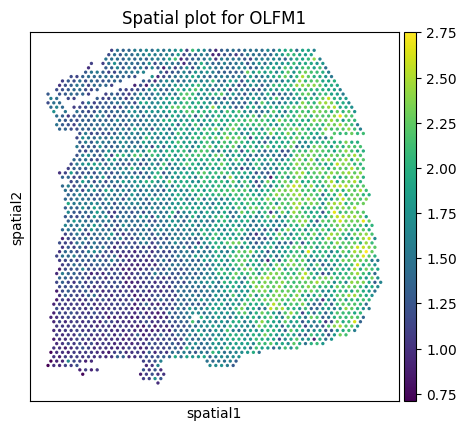

Image saved as 'figures/_spatial_gene_plot.png'


In [18]:
adata_plt = adata_cross_list[0].copy()
adata_plt.X  = np.log1p(adata_plt.X)
# --- New: Spatial Coordinate Normalization ---
print("Normalizing spatial coordinates to the [0, 10] range...")
# Get original coordinates
coords = adata_plt.obsm['spatial']

# Calculate the min and max for each axis
min_coords = coords.min(axis=0)
max_coords = coords.max(axis=0)

# Calculate the range and handle cases where the range is zero (to avoid division by zero errors)
range_coords = max_coords - min_coords
range_coords[range_coords == 0] = 1

# Apply the min-max scaling formula to scale coordinates to the [0, 10] range
scaled_coords = 10 * (coords - min_coords) / range_coords
gene_to_plot = 'OLFM1'

# Replace the old coordinates with the new, normalized ones
adata_plt.obsm['spatial'] = scaled_coords
print(f"{gene_to_plot} SCC: {adata_plt.var.loc[gene_to_plot, 'scc']}")
print("Spatial coordinate normalization complete.")
sc.pl.spatial(
    adata_plt,
    color=gene_to_plot,          # <-- Use the specified gene as the color source
    palette={'uniform': 'purple'},
    basis='spatial',
    spot_size=0.1,  # You can adjust the spot size as needed
    title=f'Spatial plot for {gene_to_plot}',
    legend_loc=None,             # <-- Add this to hide the unnecessary legend
    save='_spatial_gene_plot.png' # Save the image
)

print(f"Image saved as 'figures/_spatial_gene_plot.png'")